# Signal to Concentration

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import seaborn as sns
import pandas as pd
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
DCE-MRI data are typically acquired with spoiled gradient echo sequences (SPGR). The measured signal intensities can be converted to concentration values using the spoiled gradient echo equation as described in Schabel et al. (Phys Med Biol 2008):

$$
    S(T_1,T_2^*) = M_0 \cdot \frac{\mathrm{sin}(\alpha)(1 - e^{-\mathrm{TR}/T_1}) \cdot e^{-\mathrm{TE}/T_2^*}}{1 - e^{-\mathrm{TR}/T_1} \cdot \mathrm{cos}(\alpha)}
$$

with $S$ the measured signal intensity for spoiled gradient echo sequences, $T_1$, the longitudinal relaxation time, $T_2^*$ the transverse effective relaxation time,  $\alpha$ the flip angle, TR, the repitition time, and TE the echo time. 

By making several simplifications (e.g. $T_2^*$ is negligible) the relative signal enhancement ($\Xi$) can be expressed as (eq 5 in Schabel et al):

$$
\Xi \approx \frac{(E_1 - E_{1,0})(\mathrm{cos}(\alpha)-1)}{(E_{1,0} - 1)(E_1 \mathrm{cos}(\alpha) -1)}
$$

where $E_{1,0} = e^{-\mathrm{TR}R_{1,0}}$ and $E_{1} = e^{-\mathrm{TR}R_{1}}$, $R_1 = 1/T_1$

In this way R_1 can be solved to obtain a nonlinear approximation as (eq 6 in Schabel et al):

$$
R_1^{nl} \approx - \frac{1}{\mathrm{TR}} \cdot \mathrm{log}[\frac{\Xi(E_{1,0} - 1) + E_{1,0}(1- \mathrm{cos}(\alpha))}{1+\mathrm{cos}(\alpha)(\Xi(E_{1,0} - 1)-1)}]
$$

This leads to a nonlinear approximation of the the concentration $C$ (eq 7 in Schabel et al):

$$
C^{nl} \approx \frac{1}{r_1}(R_1^{nl} - R_{1,0})
$$

with $r_1$ is the relaxivity of the contrast agent being used.

A linear approximation can also be used (eq (8) in Schabel et al.): 

$$
C^l \approx \frac{1}{r_1}(R_{1,0}\Xi)
$$

In the current code contributions only the nonlinear approximation has been used.

## Test data
Signal intensity curves randomly selected from one patient with DCE-MRI of the uterus. They were converted to concentration using code from the University of Edinburgh but with various flip angles, baseline T1 values etc rather than the actual values used in the acquisition, to test a wider range of possibilites. For a visualization of the test data, see curves below.

Tolerances: 
absolute: 0.00001 mM/ relative 0.00001

Source: University of Edinburgh, Mechanistic substudy of UCON https://www.birmingham.ac.uk/research/bctu/trials/womens/ucon/ucon-home.aspx used with permission.  
Reference to code: Reavey, J.J., Walker, C., Nicol, M., Murray, A.A., Critchley, H.O.D., Kershaw, L.E., Maybin, J.A., 2021. Markers of human endometrial hypoxia can be detected in vivo and ex vivo during physiological menstruation. Hum. Reprod. 36, 941–950.

## Import data

In [2]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [3]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if entry['category'] == 'SI_to_Conc':
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [4]:
# label data source
df['source']=''
df.loc[df['label'].str.contains('original'),'source']='original'

author_list = df.author.unique()
no_authors = len(author_list)

voxel_list = df.label.unique()
no_voxels = len(voxel_list)

tolerances = { 'conc': {'atol' : 0.00001, 'rtol': 0.00001 }}
dt = 2.5 # in s

## Visualization of test data

To get an impression of the test data included so far, the reference concentration time curves are plotted below.

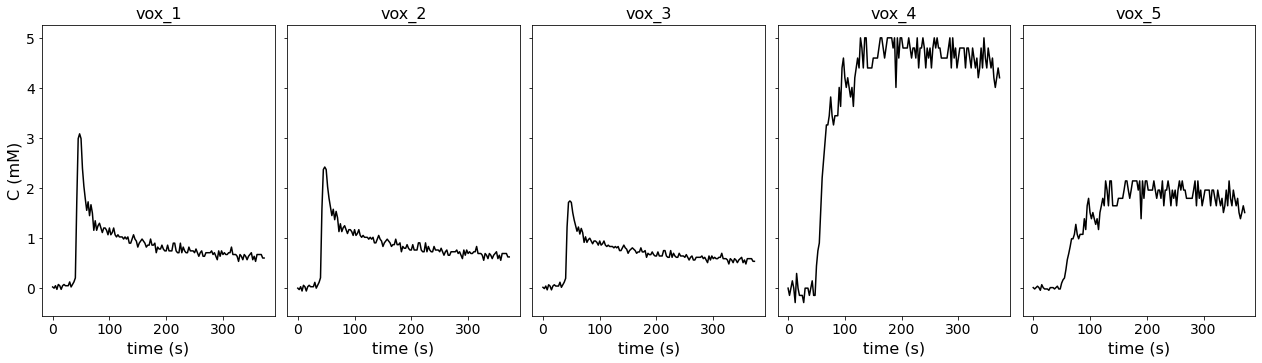

In [5]:
fig, ax = plt.subplots(1, no_voxels, sharex='col', sharey='row', figsize=(20,5))

for current_voxel in range(no_voxels):
    
    subset_data = df[(df['author'] == author_list[0]) & (df['label'] == voxel_list[current_voxel])]
    no_time_points = len(subset_data.conc_meas)
    time_array = np.arange(0, no_time_points*dt,dt)

    ax[current_voxel].plot(time_array, subset_data.conc_ref, color='black', label='ref')

    if current_voxel == 0:
        ax[current_voxel].set_ylabel('C (mM)', fontsize=16)
    
    ax[current_voxel].set_xlabel('time (s)', fontsize=16)
    ax[current_voxel].set_title(voxel_list[current_voxel], fontsize=16)
    
    # set fontsize
    ax[current_voxel].tick_params(axis='x', labelsize=14)
    ax[current_voxel].tick_params(axis='y', labelsize=14)
 

fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)
plt.show()


Plot bland altman figure of error between output concentration values and reference values vs the reference values. All datapoints are combined into one figure in this case

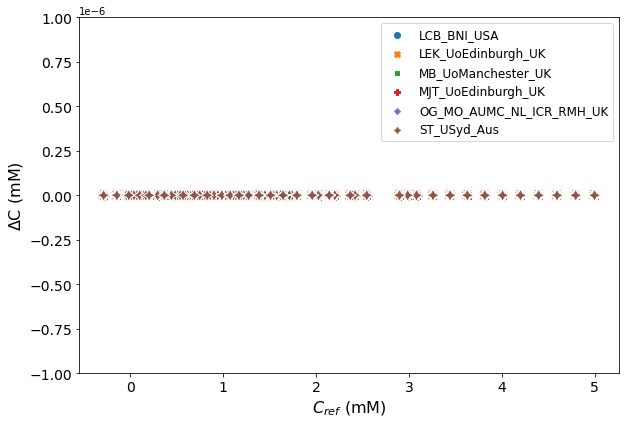

In [6]:
# calculate error between measured and reference R_1 values
df['error_conc'] = df['conc_meas'] - df['conc_ref']

fig, ax = plt.subplots(1,1, sharey='none', figsize=(9,6))
plot_bland_altman(ax, df, tolerances, 'conc', ylim=(-0.000001,0.000001),label_xaxis='$C_{ref}$ (mM)',label_yaxis='$\Delta $C (mM)')
plt.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

                        

Calculate bias and limits of agreement for all contributions wrt the reference values. 
The differences between measured and reference values are really small for the current test data. There are slight differences between contributions, that can be attributed due to slight diferences in implementations.

In [7]:
resultsBA = bland_altman_statistics(data=df,par='error_conc',grouptag='author')

print('Bias results estimated concentration values combined for all voxels')
print(resultsBA)

Bias results estimated concentration values combined for all voxels
                                  bias         stdev     LoA lower  \
author                                                               
LCB_BNI_USA               6.074475e-15  1.201209e-14 -1.746922e-14   
LEK_UoEdinburgh_UK       -4.150754e-16  2.149516e-15 -4.628126e-15   
MB_UoManchester_UK        1.087938e-15  9.074768e-15 -1.669861e-14   
MJT_UoEdinburgh_UK       -3.449652e-14  8.838840e-14 -2.077378e-13   
OG_MO_AUMC_NL_ICR_RMH_UK -4.048292e-16  2.153874e-15 -4.626423e-15   
ST_USyd_Aus               2.226577e-16  1.183484e-14 -2.297363e-14   

                             LoA upper  
author                                  
LCB_BNI_USA               2.961818e-14  
LEK_UoEdinburgh_UK        3.797976e-15  
MB_UoManchester_UK        1.887448e-14  
MJT_UoEdinburgh_UK        1.387447e-13  
OG_MO_AUMC_NL_ICR_RMH_UK  3.816765e-15  
ST_USyd_Aus               2.341895e-14  


## Notes

Check the test code for modification in input data to be able to run the tests. 

### References

Schabel MC and Parker DL "Uncertainty and bias in contrast concentration measurements using spoiled gradient echo pulse sequences" Phys Med Biol (2008), doi:10.1088/0031-9155/53/9/010

